## Splitting Data into Training, Validation, and Test sets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# set seaborn style
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import cleaned data
AAPL_Clean = pd.read_csv('/Users/meiliu/Documents/SpringBoard Related/AAPL_Clean.csv')
AAPL_Clean.drop('Unnamed: 0', axis=1, inplace=True)

# convert date to datetime
AAPL_Clean['date']=pd.to_datetime(AAPL_Clean['date'])

AAPL_Clean.head()

,date,DCLRDT,DIVAMT,PRC,VOL,OPENPRC,NUMTRD,sprtrn,dayofweek,month,year,HISPRD,SPRD,OCdiff,TREND,Announce,Surprise
0,2013-01-02,0,0.0,78.432861,147260365,79.117144,1057287,0.025403,2,1,2013,0.024685,0.000018,0.008724,19,0.0,NaN
1,2013-01-03,0,0.0,77.442270,93079714,78.268571,668164,-0.002086,3,1,2013,0.016026,0.000313,0.010670,19,0.0,NaN
2,2013-01-04,0,0.0,75.285714,154612668,76.709290,1062607,0.004865,4,1,2013,0.024345,0.000380,0.018909,19,0.0,NaN
3,2013-01-07,0,0.0,74.842860,126121317,74.571429,895454,-0.003123,0,1,2013,0.027368,0.000420,-0.003627,19,0.0,NaN
4,2013-01-08,0,0.0,75.044286,118417425,75.601431,796341,-0.003242,1,1,2013,0.020412,0.000457,0.007424,19,0.0,NaN


In [3]:
# split data into train and test sets
def testsplit(df, test_size=10):
    train_data = df[:-test_size]
    test_data = df[-test_size:]
    return train_data, test_data

# split training set into train and validation
def validsplit2(train, n_folds=10, test_size=10):
    fold = int(len(train)/n_folds)
    h_start = []
    h_end = [] 
    for x in list(range(n_folds)):
        h_start.append(fold*(x+1)-test_size)
        h_end.append(fold*(x+1))
    return h_start, h_end #index start and end values for validation holdout


train_data, test_data = testsplit(AAPL_Clean)
h_start, h_end = validsplit2(train_data)

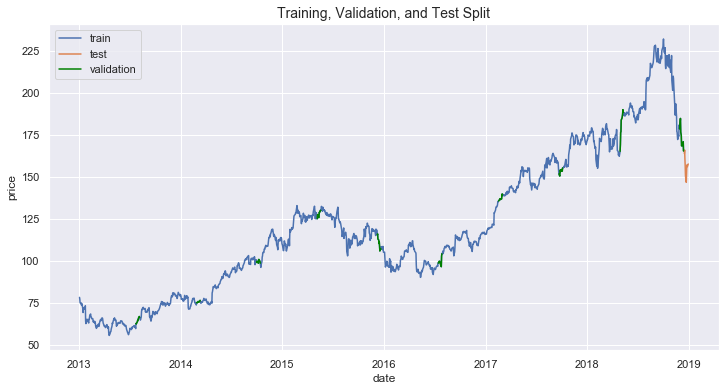

In [4]:
# create validation holdout using the the holdout index values
AAPL_holdout = AAPL_Clean[h_start[0]:h_end[0]]
for i in range(1,10):
    AAPL_holdout = AAPL_holdout.append(AAPL_Clean[h_start[i]:h_end[i]])

# plot to visually show validation holdout and test holdout sets
plt.figure(figsize=(12,6))
plt.plot(train_data.set_index('date')['PRC'], label='train')
plt.plot(test_data.set_index('date')['PRC'], label='test')
plt.plot(AAPL_holdout.set_index('date')['PRC'][:10], color='green', label='validation')
for i in range(1,10):
    plt.plot(AAPL_holdout.set_index('date')['PRC'][i*10:(i+1)*10], color='green')
plt.xlabel('date')
plt.ylabel('price')
plt.title('Training, Validation, and Test Split', size=14)
plt.legend();

## Forecasting Models I: Using only historical price

### Simple Moving Average

In [5]:
# RMSE calculation function
def rmse(pred, target):
    return np.sqrt(((pred - target) ** 2).mean())

In [6]:
# moving average prediction incorporating forecasted values (training data only)
# predicts the closing price for the next 10 trading days
def MovingAvgPred(window, h_start=h_start, data=AAPL_Clean, test_size=10, col='PRC'):
    pred = []
    N = int(len(h_start))
    for n in range(N):
        h_num = n
        psum=0
        if len(pred)-n*N < window:
            for i in range(min(window,test_size)):
                tsum = data.reset_index()[col][h_start[n]-(window-i):h_start[n]].sum()
                if i != 0:
                    psum = sum(pred[-i:])
                pred.append((tsum+psum)/window)
                
        for i in range(max(0,test_size-window)):
            psum = sum(pred[-window:])
            pred.append(psum/window)
            
    return pred

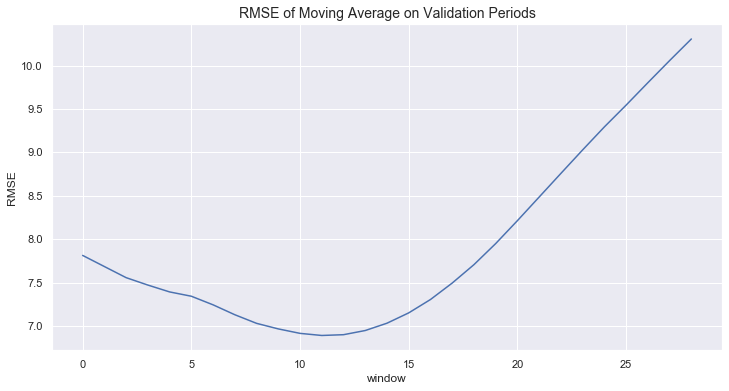

In [7]:
# calculate the RMSE of moving averages with windows from 1( aka Last Value) to 30 periods
MA_RMSE = []
for i in range(1,30):
    RMSE = rmse(MovingAvgPred(i), AAPL_holdout.PRC)
    MA_RMSE.append(RMSE)


plt.figure(figsize=(12,6))
plt.plot(MA_RMSE)
plt.xlabel('window')
plt.ylabel('RMSE')
plt.title('RMSE of Moving Average on Validation Periods', size=14);

In [8]:
# find the moving average window with the lowest error on the validation set
print('A moving average with a {} period window has the minimum RMSE of {}'
      .format(MA_RMSE.index(min(MA_RMSE))+1, min(MA_RMSE)))

A moving average with a 12 period window has the minimum RMSE of 6.891380786774005


In [9]:
# use the 12-period moving average to predict the test values
test_pred = MovingAvgPred(12, h_start=[1500])
print('Using a 12 period moving average, the prediction on the test data has a RMSE of', rmse(test_pred, test_data.PRC))

Using a 12 period moving average, the prediction on the test data has a RMSE of 15.264494511853222


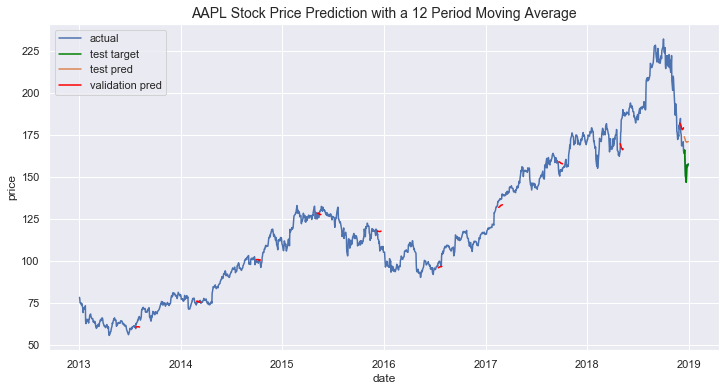

In [11]:
plt.figure(figsize=(12,6))
plt.plot(AAPL_Clean.set_index('date')['PRC'], label='actual')
plt.plot(test_data.set_index('date')['PRC'], color='green', label='test target')
plt.plot(test_data['date'], test_pred, label='test pred')
plt.plot(AAPL_holdout['date'][0:10], MovingAvgPred(12)[0:10], color='red', label='validation pred')
for i in range(1,10):
    plt.plot(AAPL_holdout['date'][i*10:(i+1)*10], MovingAvgPred(12)[i*10:(i+1)*10], color='red')
plt.xlabel('date')
plt.ylabel('price')
plt.title('AAPL Stock Price Prediction with a 12 Period Moving Average', size=14)
plt.legend();

### ARIMA Model

In [11]:
# Test for non-stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_data.PRC)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.962266
p-value: 0.766777


In [12]:
# estimate values for d and D to use in autoarima
from pmdarima.arima import ndiffs, nsdiffs

print('d: ', ndiffs(train_data.PRC, test='adf'))
print('D: ', nsdiffs(train_data.PRC, 12))

d:  1
D:  0


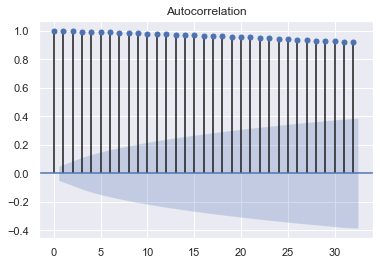

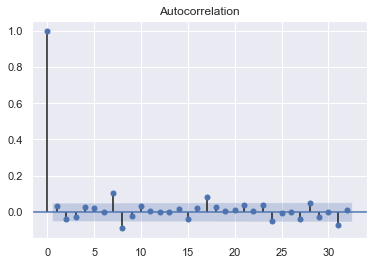

In [13]:
# below, we can visually confirm that d=1:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train_data.PRC)
plot_acf(train_data.PRC.diff().dropna());

In [12]:
from pmdarima import auto_arima

model = auto_arima(train_data.PRC, start_p=1, start_q=1,max_p=5, max_q=3, m=12,start_P=0, 
                   seasonal=True,d=1, D=0, trace=True,error_action='ignore',suppress_warnings=True)

# fit the autoarima model to the training data
model.fit(train_data.PRC)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=6257.777, BIC=6284.340, Fit time=2.190 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=6254.362, BIC=6264.987, Fit time=0.064 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=6256.719, BIC=6277.970, Fit time=0.730 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=6256.570, BIC=6277.820, Fit time=0.801 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=6253.696, BIC=6259.009, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=6256.355, BIC=6272.293, Fit time=0.395 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=6256.354, BIC=6272.292, Fit time=0.432 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 12); AIC=6249.119, BIC=6270.369, Fit time=3.007 seconds
Near non-invertible roots for order (0, 1, 0)(1, 0, 1, 12); setting score to inf (at least one inverse root too close to the border of t

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 0, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [13]:
# forecast the next 10 periods
forecast = model.predict(n_periods=10)

# calculate the RMSE of the test predictions
rmse(forecast, test_data.PRC)

10.861911505938162

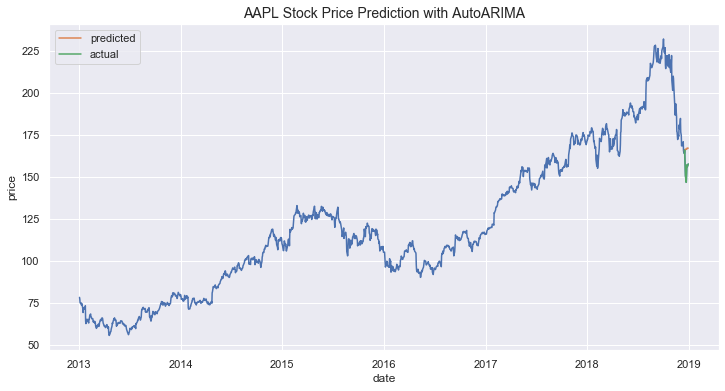

In [15]:
plt.figure(figsize=(12,6))
plt.plot(AAPL_Clean.set_index('date')['PRC'])
plt.plot(test_data['date'], forecast, label='predicted')
plt.plot(test_data.set_index('date')['PRC'], label='actual')
plt.xlabel('date')
plt.ylabel('price')
plt.title('AAPL Stock Price Prediction with AutoARIMA', size=14)
plt.legend();

### FB Prophet

In [16]:
from fbprophet import Prophet

# create a training data dataframe in the Prophet format
train_prophet = pd.DataFrame(index=list(range(len(train_data))), columns=['ds', 'y'])
train_prophet['ds'] = train_data['date']
train_prophet['y'] = train_data.reset_index()['PRC']
train_prophet.head()

,ds,y
0,2013-01-02,78.432861
1,2013-01-03,77.442270
2,2013-01-04,75.285714
3,2013-01-07,74.842860
4,2013-01-08,75.044286


In [23]:
# fit the model on the training data
model=Prophet(daily_seasonality=True)
model.fit(train_prophet)

In [24]:
# forecast the test values and calculate the RMSE
pred_prophet = pd.DataFrame(index=list(range(10)), columns=['ds'])
pred_prophet['ds']=test_data.reset_index()['date']

forecast = model.predict(pred_prophet)

print(rmse(forecast['yhat'], test_data.reset_index()['PRC']))

51.93676557333648


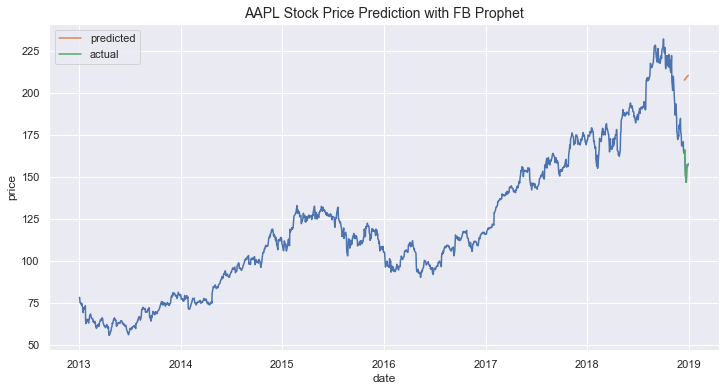

In [28]:
plt.figure(figsize=(12,6))
plt.plot(AAPL_Clean.set_index('date')['PRC'])
plt.plot(forecast['ds'], forecast['yhat'], label='predicted')
plt.plot(test_data.set_index('date')['PRC'], label='actual')
plt.xlabel('date')
plt.ylabel('price')
plt.title('AAPL Stock Price Prediction with FB Prophet', size=14)
plt.legend();

### XGBoost
#### Feature Selection

In [71]:
# select only the price and date variables
AAPL_XGB = AAPL_Clean[['date','PRC', 'month', 'year', 'dayofweek']]

# create additional features based on date
AAPL_XGB['qtr'] = AAPL_XGB['date'].dt.quarter
AAPL_XGB['day365'] = AAPL_XGB['date'].dt.dayofyear
AAPL_XGB['dayofmonth'] = AAPL_XGB['date'].dt.day
AAPL_XGB['weekofyear'] = AAPL_XGB['date'].dt.weekofyear
AAPL_XGB['day_no']=AAPL_XGB.index + 1
# start or end of the week (Mon or Fri)
AAPL_XGB['startend'] =  np.where(AAPL_XGB["dayofweek"].isin(["0", "4"]), 1, 0)

In [72]:
# train test split
train_XGB, test_XGB = testsplit(AAPL_XGB)

In [73]:
# functions to create lag features in training data
def lag_mean_train(col, lags):
    for c in col:
        for x in range(len(lags)):
            train_XGB['{}_moving_mean_{}'.format(c, lags[x])] = train_XGB[c].shift(1).rolling(lags[x]).mean()

def lag_median_train(col, lags):
    for c in col:
        for x in range(len(lags)):
            train_XGB['{}_moving_median_{}'.format(c, lags[x])] = train_XGB[c].shift(1).rolling(lags[x]).median()

def lag_min_train(col, lags):
    for c in col:
        for x in range(len(lags)):
            train_XGB['{}_moving_min_{}'.format(c, lags[x])] = train_XGB[c].shift(1).rolling(lags[x]).min()

def lag_max_train(col, lags):
    for c in col:
        for x in range(len(lags)):
            train_XGB['{}_moving_max_{}'.format(c, lags[x])] = train_XGB[c].shift(1).rolling(lags[x]).max()

In [74]:
# functions to extend lag features to test data:

# calculate moving average
def lag_mean_test(col, lags):
    for c in col:
        for x in range(len(lags)):
            test_XGB['{}_moving_mean_{}'.format(c, lags[x])] = MovingAvgPred(5, h_start=[1500], col=c)

# extend the last value of the moving median, min, max from the training data to the test data
def lag_median_test(col, lags):
    for c in col:
        for x in range(len(lags)):
            test_XGB['{}_moving_median_{}'.format(c, lags[x])] = [train_XGB['{}_moving_median_{}'.format(c, lags[x])].iloc[-1]]*10

def lag_max_test(col, lags):
    for c in col:
        for x in range(len(lags)):
            test_XGB['{}_moving_max_{}'.format(c, lags[x])] = [train_XGB['{}_moving_max_{}'.format(c, lags[x])].iloc[-1]]*10

def lag_min_test(col, lags):
    for c in col:
        for x in range(len(lags)):
            test_XGB['{}_moving_min_{}'.format(c, lags[x])] = [train_XGB['{}_moving_min_{}'.format(c, lags[x])].iloc[-1]]*10




In [75]:
# short term lags of 5,10,15 for moving mean and median
# additional long term lag of 50 for max and min

lags1 = [5,10,15]
lags2 = [5,10,15,50]
col = ['PRC']

# create closing price lag features for training data
lag_mean_train(col, lags1)
lag_median_train(col, lags1)
lag_min_train(col, lags2)
lag_max_train(col, lags2)

# create closing price lag features for test data
lag_mean_test(col, lags1)
lag_median_test(col, lags1)
lag_min_test(col, lags2)
lag_max_test(col, lags2)

In [76]:
# create encodes using training data and merge to both training and test data
def encode_traintest(col, train_XGB, test_XGB):
    for c in col:
        week_encode = train_XGB.groupby('weekofyear')[c].mean().rename('{}_week_encode'.format(c))
        month_encode = train_XGB.groupby('month')[c].mean().rename('{}_month_encode'.format(c))
        year_encode = train_XGB.groupby('year')[c].mean().rename('{}_year_encode'.format(c))

            # merge encodes to training and test data
        encodes = [week_encode, month_encode, year_encode]
        encode_type = ['weekofyear', 'month', 'year']

        for i in range(3):
            train_XGB = pd.merge(train_XGB, encodes[i], left_on=train_XGB[encode_type[i]], right_on=encodes[i].index, how='left').drop('key_0', axis=1)
            test_XGB = pd.merge(test_XGB, encodes[i], left_on=test_XGB[encode_type[i]], right_on=encodes[i].index, how='left').drop('key_0', axis=1)
    return train_XGB, test_XGB

In [77]:
# create & merge encodes
train_XGB, test_XGB = encode_traintest(['PRC'],train_XGB, test_XGB)

In [78]:
# remove the rows with NaN values (first 50 rows) from the training data
train_XGB.dropna(inplace=True)

train_XGB.head()

,date,PRC,month,year,dayofweek,qtr,day365,dayofmonth,weekofyear,day_no,...,PRC_moving_min_10,PRC_moving_min_15,PRC_moving_min_50,PRC_moving_max_5,PRC_moving_max_10,PRC_moving_max_15,PRC_moving_max_50,PRC_week_encode,PRC_month_encode,PRC_year_encode
50,2013-03-15,63.380000,3,2013,4,1,74,15,11,51,...,60.007141,60.007141,60.007141,62.552857,62.552857,64.401429,78.432861,114.427239,114.929545,67.51926
51,2013-03-18,65.102857,3,2013,0,1,77,18,12,52,...,60.007141,60.007141,60.007141,63.380000,63.380000,64.138571,77.442270,114.556922,114.929545,67.51926
52,2013-03-19,64.927141,3,2013,1,1,78,19,12,53,...,60.808856,60.007141,60.007141,65.102857,65.102857,65.102857,75.285714,114.556922,114.929545,67.51926
53,2013-03-20,64.582856,3,2013,2,1,79,20,12,54,...,60.808856,60.007141,60.007141,65.102857,65.102857,65.102857,75.044286,114.556922,114.929545,67.51926
54,2013-03-21,64.675716,3,2013,3,1,80,21,12,55,...,61.192859,60.007141,60.007141,65.102857,65.102857,65.102857,75.044286,114.556922,114.929545,67.51926


In [79]:
# target is PRC
y_train = train_XGB['PRC']
X_train = train_XGB.drop(['PRC', 'date'], axis=1)
print(X_train.columns)

y_test = test_XGB['PRC']
X_test = test_XGB.drop(['PRC', 'date'], axis=1)

Index(['month', 'year', 'dayofweek', 'qtr', 'day365', 'dayofmonth',
       'weekofyear', 'day_no', 'startend', 'PRC_moving_mean_5',
       'PRC_moving_mean_10', 'PRC_moving_mean_15', 'PRC_moving_median_5',
       'PRC_moving_median_10', 'PRC_moving_median_15', 'PRC_moving_min_5',
       'PRC_moving_min_10', 'PRC_moving_min_15', 'PRC_moving_min_50',
       'PRC_moving_max_5', 'PRC_moving_max_10', 'PRC_moving_max_15',
       'PRC_moving_max_50', 'PRC_week_encode', 'PRC_month_encode',
       'PRC_year_encode'],
      dtype='object')


#### Hyperparamter Tuning

In [38]:
from xgboost import XGBRegressor

In [39]:
def mape(pred, target): 
    return (np.abs(target - pred) / target).mean() * 100

In [40]:
# check default parameters for XGBoost to create grid search parameters
XGBRegressor(eval_metric='rmse')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

#### booster='gbtree'

In [41]:
# set initial values for tuning parameters
n_estimators_1 = 100
max_depth_1 = 8
min_child_weight_1 = 1
subsample_1 = 0.8
colsample_bytree_1 = 0.8
gamma_1 = 0

In [42]:
# adjust the holdout index values for the first 50 removed rows
h_start_xgb = np.array(h_start)-50
h_end_xgb = np.array(h_end)-50

In [43]:
def n_estimators_tune(start, stop, stepsize, booster_1='gbtree'):
    best_mape = 1000 # initialize val
    
    for n in range(start, stop, stepsize):
        model = XGBRegressor(n_estimators=n, booster=booster_1, eval_metric='rmse', eta=0.03, 
                             max_depth=max_depth_1, min_child_weight=min_child_weight_1, 
                             subsample=subsample_1,colsample_bytree=colsample_bytree_1, gamma=gamma_1, silent=1)
        
        mape_n=[]
        for i in range(len(h_start)):
            model.fit(X_train[:h_start_xgb[i]], y_train[:h_start_xgb[i]])
            pred = model.predict(X_train[h_start_xgb[i]:h_end_xgb[i]])
            mape_n.append(mape(pred, y_train[h_start_xgb[i]:h_end_xgb[i]]))

        if np.mean(mape_n) < best_mape:
            best_mape = np.mean(mape_n)
            best_value = n
        
    print('n_estimators={} has the lowest mape: {}'.format(best_value, best_mape))
    return  best_value

In [44]:
def gamma_tune(start, stop, stepsize, booster_1='gbtree'):
    best_mape = 1000 # initialize val
    
    for n in range(start, stop, stepsize):
        mape_n=[]
        model = XGBRegressor(gamma=n, booster=booster_1, eval_metric='rmse', eta=0.03, 
                             n_estimators=n_estimators_1, max_depth=max_depth_1, min_child_weight=min_child_weight_1,
                             subsample=subsample_1, colsample_bytree=colsample_bytree_1, silent=1)
        
        for i in range(len(h_start)):
            model.fit(X_train[:h_start_xgb[i]], y_train[:h_start_xgb[i]])
            pred = model.predict(X_train[h_start_xgb[i]:h_end_xgb[i]])
            mape_n.append(mape(pred, y_train[h_start_xgb[i]:h_end_xgb[i]]))

        if np.mean(mape_n) < best_mape:
            best_mape = np.mean(mape_n)
            best_value = n
    print('gamma={} has the lowest mape: {}'.format(best_value, best_mape))  
    return  best_value

In [45]:
# enter inputs as pecentage 
def sample_tune(start_sub, stop_sub, start_col, stop_col, stepsize1, stepsize2=None, booster_1='gbtree'):
    best_mape = 1000 # initialize val
    
    if stepsize2==None:
        stepsize2=stepsize1
    
    for s in range(start_sub, stop_sub, stepsize1):
        for c in range(start_col, stop_col, stepsize2):
            mape_n=[]
            model = XGBRegressor(subsample=s/100, colsample_bytree=c/100, booster=booster_1, eval_metric='rmse', eta=0.03, 
                                 n_estimators=n_estimators_1, max_depth=max_depth_1, min_child_weight=min_child_weight_1,
                                 gamma=gamma_1, silent=1)

            for i in range(len(h_start)):
                model.fit(X_train[:h_start_xgb[i]], y_train[:h_start_xgb[i]])
                pred = model.predict(X_train[h_start_xgb[i]:h_end_xgb[i]])
                mape_n.append(mape(pred, y_train[h_start_xgb[i]:h_end_xgb[i]]))

            if np.mean(mape_n) < best_mape:
                best_mape = np.mean(mape_n)
                best_value1 = s/100
                best_value2 = c/100
    print('subsample={} and colsample_bytree={} has the lowest mape: {}'.format(best_value1, best_value2, best_mape))  
    return  best_value1, best_value2

In [46]:
def depth_weight_tune(start_depth, stop_depth, start_weight, stop_weight, stepsize1, stepsize2=None, booster_1='gbtree'):
    best_mape = 1000 # initialize val
    
    if stepsize2==None:
        stepsize2=stepsize1
    
    for d in range(start_depth, stop_depth, stepsize1):
        for w in range(start_weight, stop_weight, stepsize2):
            mape_n=[]
            model = XGBRegressor(max_depth=d, min_child_weight=w, booster=booster_1, eval_metric='rmse', eta=0.03, 
                             n_estimators=n_estimators_1,
                             subsample=subsample_1, colsample_bytree=colsample_bytree_1, gamma=gamma_1, silent=1)

            for i in range(len(h_start)):
                model.fit(X_train[:h_start_xgb[i]], y_train[:h_start_xgb[i]])
                pred = model.predict(X_train[h_start_xgb[i]:h_end_xgb[i]])
                mape_n.append(mape(pred, y_train[h_start_xgb[i]:h_end_xgb[i]]))

            if np.mean(mape_n) < best_mape:
                best_mape = np.mean(mape_n)
                best_value1 = d
                best_value2 = w
    print('max_depth={} and min_child_weight={} has the lowest mape: {}'.format(best_value1, best_value2, best_mape))  
    return  best_value1, best_value2

In [105]:
n_estimators_1 = n_estimators_tune(50,500,50)

n_estimators=150 has the lowest mape: 2.928263107353854


In [106]:
gamma_1 = gamma_tune(0, 8, 1)

gamma=5 has the lowest mape: 2.709644306040711


In [107]:
subsample_1, colsample_bytree_1 = sample_tune(50,100,50,100,10)

subsample=0.7 and colsample_bytree=0.6 has the lowest mape: 2.5949477963571814


In [108]:
max_depth_1, min_child_weight_1 = depth_weight_tune(3,12,1,10,1)

max_depth=10 and min_child_weight=2 has the lowest mape: 2.5310465756272635


In [109]:
print('Tuned Parameter Values:\n n_estimators={},\n max_depth={},\n min_child_weight={},\n subsample={},\n colsample_bytree={},\n gamma={}'.format(n_estimators_1, max_depth_1, min_child_weight_1, subsample_1, colsample_bytree_1, gamma_1))

Tuned Parameter Values:
 n_estimators=150,
 max_depth=10,
 min_child_weight=2,
 subsample=0.7,
 colsample_bytree=0.6,
 gamma=5


In [80]:
model = XGBRegressor(booster='gbtree', eval_metric='rmse', eta=0.03,
             n_estimators=150,
 max_depth=10,
 min_child_weight=2,
 subsample=0.7,
 colsample_bytree=0.6,
 gamma=5, silent=1)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eta=0.03,
             eval_metric='rmse', gamma=5, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=2, missing=None, n_estimators=150, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.7, verbosity=1)

In [212]:
model = XGBRegressor(booster='gbtree', eval_metric='rmse', eta=0.03,
             n_estimators=n_estimators_1, max_depth=max_depth_1, min_child_weight=min_child_weight_1,
             subsample=subsample_1,colsample_bytree=colsample_bytree_1, gamma=gamma_1, silent=1)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, eta=0.03,
             eval_metric='rmse', gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=450, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.5, verbosity=1)

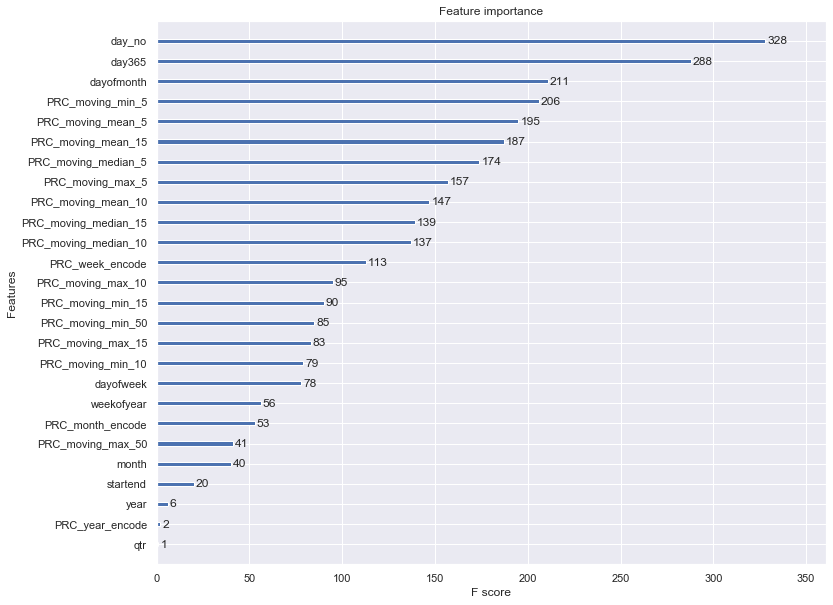

In [81]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12, 10))
plot_importance(model, ax=ax);

In [48]:
y_pred = model.predict(X_test)
print('RMSE of test prediction:', rmse(y_pred, y_test))
print('MAPE of test prediction:', mape(y_pred, y_test))

RMSE of test prediction: 10.743486380513573
MAPE of test prediction: 6.049375281546961


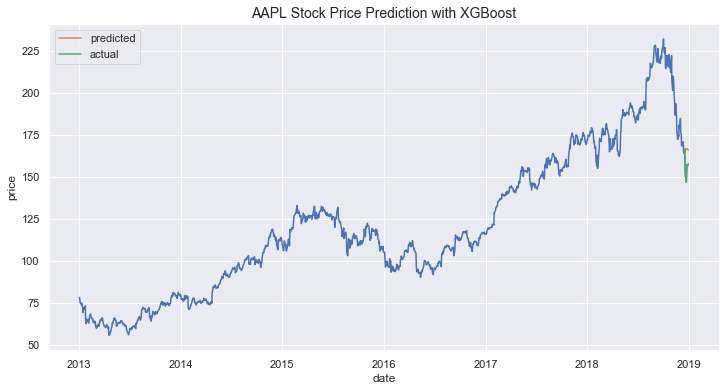

In [218]:
plt.figure(figsize=(12,6))
plt.plot(AAPL_Clean.set_index('date')['PRC'])
plt.plot(test_data['date'], y_pred, label='predicted')
plt.plot(test_data.set_index('date')['PRC'], label='actual')
plt.xlabel('date')
plt.ylabel('price')
plt.title('AAPL Stock Price Prediction with XGBoost', size=14)
plt.legend();

#### booster='gblinear'

In [120]:
# set initial values for tuning parameters
n_estimators_1 = 100
max_depth_1 = 8
min_child_weight_1 = 1
subsample_1 = 0.8
colsample_bytree_1 = 0.8
gamma_1 = 0

In [121]:
XGBRegressor(booster='gblinear')

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [122]:
n_estimators_1 = n_estimators_tune(50,500,50,booster_1='gblinear')

n_estimators=450 has the lowest mape: 2.9861138811007293


In [123]:
gamma_1 = gamma_tune(0, 8, 1, booster_1='gblinear')

gamma=0 has the lowest mape: 2.9861138811007293


In [129]:
subsample_1, colsample_bytree_1 = sample_tune(50,100,50,100,10, booster_1='gblinear')

subsample=0.5 and colsample_bytree=0.5 has the lowest mape: 2.9861138811007293


In [133]:
max_depth_1, min_child_weight_1 = depth_weight_tune(3,12,1,10,1, booster_1='gblinear')

max_depth=3 and min_child_weight=1 has the lowest mape: 2.9861138811007293


In [134]:
print('Tuned Parameter Values:\n n_estimators={},\n max_depth={},\n min_child_weight={},\n subsample={},\n colsample_bytree={},\n gamma={}'.format(n_estimators_1, max_depth_1, min_child_weight_1, subsample_1, colsample_bytree_1, gamma_1))

Tuned Parameter Values:
 n_estimators=450,
 max_depth=3,
 min_child_weight=1,
 subsample=0.5,
 colsample_bytree=0.5,
 gamma=0


In [82]:
model = XGBRegressor(booster='gblinear', eval_metric='rmse', eta=0.03,
             n_estimators=450,
 max_depth=3,
 min_child_weight=1,
 subsample=0.5,
 colsample_bytree=0.5,
 gamma=0, silent=1)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, eta=0.03,
             eval_metric='rmse', gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=450, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.5, verbosity=1)

In [135]:
model = XGBRegressor(booster='gblinear', eval_metric='rmse', eta=0.03,
             n_estimators=n_estimators_1, max_depth=max_depth_1, min_child_weight=min_child_weight_1,
             subsample=subsample_1,colsample_bytree=colsample_bytree_1, gamma=gamma_1, silent=1)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, eta=0.03,
             eval_metric='rmse', gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=450, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.5, verbosity=1)

In [220]:
y_pred = model.predict(X_test)
print('RMSE of test prediction:', rmse(y_pred, y_test))
print('MAPE of test prediction:', mape(y_pred, y_test))

RMSE of test prediction: 17.75094416686915
MAPE of test prediction: 10.90135677482002


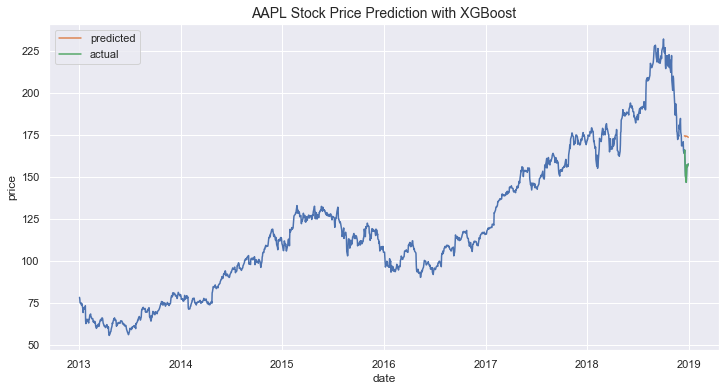

In [221]:
plt.figure(figsize=(12,6))
plt.plot(AAPL_Clean.set_index('date')['PRC'])
plt.plot(test_data['date'], y_pred, label='predicted')
plt.plot(test_data.set_index('date')['PRC'], label='actual')
plt.xlabel('date')
plt.ylabel('price')
plt.title('AAPL Stock Price Prediction with XGBoost', size=14)
plt.legend();

## Forecasting Models II: Using multiple features
#### Feature Selection

In [54]:
# select all variables
AAPL_XGB = AAPL_Clean

# create additional features based on date
AAPL_XGB['qtr'] = AAPL_XGB['date'].dt.quarter
AAPL_XGB['day365'] = AAPL_XGB['date'].dt.dayofyear
AAPL_XGB['dayofmonth'] = AAPL_XGB['date'].dt.day
AAPL_XGB['weekofyear'] = AAPL_XGB['date'].dt.weekofyear
AAPL_XGB['day_no']=AAPL_XGB.index + 1
# start or end of the week (Mon or Fri)
AAPL_XGB['startend'] =  np.where(AAPL_XGB["dayofweek"].isin(["0", "4"]), 1, 0)

In [55]:
# train test split
train_XGB, test_XGB = testsplit(AAPL_XGB)

In [56]:
# short term lags of 5,10,15 for moving mean and median
# additional long term lag of 50 for max and min

lags1 = [5,10,15]
lags2 = [5,10,15,50]
col = ['PRC', 'VOL', 'NUMTRD', 'sprtrn', 'HISPRD', 'SPRD', 'OCdiff']

# create closing price lag features for training data
lag_mean_train(col, lags1)
lag_median_train(col, lags1)
lag_min_train(col, lags2)
lag_max_train(col, lags2)

# create closing price lag features for test data
lag_mean_test(col, lags1)
lag_median_test(col, lags1)
lag_min_test(col, lags2)
lag_max_test(col, lags2)

In [57]:
# create encodes on price
train_XGB, test_XGB = encode_traintest(['PRC'], train_XGB, test_XGB)

In [58]:
# remove the rows with NaN values (first 50 rows) from the training data
train_XGB.dropna(inplace=True)

train_XGB.head()

,date,DCLRDT,DIVAMT,PRC,VOL,OPENPRC,NUMTRD,sprtrn,dayofweek,month,...,SPRD_moving_max_10,SPRD_moving_max_15,SPRD_moving_max_50,OCdiff_moving_max_5,OCdiff_moving_max_10,OCdiff_moving_max_15,OCdiff_moving_max_50,PRC_week_encode,PRC_month_encode,PRC_year_encode
50,2013-03-15,0,0.0,63.380000,166699778,62.561427,1014804,-0.001618,4,3,...,0.00056,0.00056,0.00056,0.016736,0.020786,0.024955,0.026848,114.427239,114.929545,67.51926
51,2013-03-18,0,0.0,65.102857,156891679,63.064287,999432,-0.005510,0,3,...,0.00056,0.00056,0.00056,0.016736,0.020786,0.024955,0.026848,114.556922,114.929545,67.51926
52,2013-03-19,0,0.0,64.927141,138683853,65.642857,966812,-0.002423,1,3,...,0.00056,0.00056,0.00056,0.016736,0.020786,0.020786,0.026848,114.556922,114.929545,67.51926
53,2013-03-20,0,0.0,64.582856,79814847,65.345716,540218,0.006697,2,3,...,0.00056,0.00056,0.00056,0.011023,0.020786,0.020786,0.026848,114.556922,114.929545,67.51926
54,2013-03-21,0,0.0,64.675716,100521904,64.317143,683256,-0.008282,3,3,...,0.00056,0.00056,0.00056,0.011812,0.016736,0.020786,0.026848,114.556922,114.929545,67.51926


In [59]:
train_XGB.columns[:25]

Index(['date', 'DCLRDT', 'DIVAMT', 'PRC', 'VOL', 'OPENPRC', 'NUMTRD', 'sprtrn',
       'dayofweek', 'month', 'year', 'HISPRD', 'SPRD', 'OCdiff', 'TREND',
       'Announce', 'Surprise', 'qtr', 'day365', 'dayofmonth', 'weekofyear',
       'day_no', 'startend', 'PRC_moving_mean_5', 'PRC_moving_mean_10'],
      dtype='object')

In [60]:
# target is PRC
# drop variables such as VOL which are only used to generate lag features
y_train = train_XGB['PRC']
X_train = train_XGB.drop(['PRC', 'date', 'VOL', 'OPENPRC', 'NUMTRD', 'sprtrn',
       'HISPRD', 'SPRD', 'OCdiff'], axis=1)
print(X_train.columns)

y_test = test_XGB['PRC']
X_test = test_XGB.drop(['PRC', 'date', 'VOL', 'OPENPRC', 'NUMTRD', 'sprtrn',
        'HISPRD', 'SPRD', 'OCdiff'], axis=1)

Index(['DCLRDT', 'DIVAMT', 'dayofweek', 'month', 'year', 'TREND', 'Announce',
       'Surprise', 'qtr', 'day365',
       ...
       'SPRD_moving_max_10', 'SPRD_moving_max_15', 'SPRD_moving_max_50',
       'OCdiff_moving_max_5', 'OCdiff_moving_max_10', 'OCdiff_moving_max_15',
       'OCdiff_moving_max_50', 'PRC_week_encode', 'PRC_month_encode',
       'PRC_year_encode'],
      dtype='object', length=115)


#### Hyperparameter Tuning

#### booster='gbtree'

In [84]:
# set initial values for tuning parameters
n_estimators_1 = 100
max_depth_1 = 8
min_child_weight_1 = 1
subsample_1 = 0.8
colsample_bytree_1 = 0.8
gamma_1 = 0

In [85]:
n_estimators_1 = n_estimators_tune(50,500,50)

n_estimators=200 has the lowest mape: 3.063129251347435


In [86]:
gamma_1 = gamma_tune(0, 8, 1)

gamma=3 has the lowest mape: 2.71740122618946


In [87]:
subsample_1, colsample_bytree_1 = sample_tune(50,100,50,100,10)

subsample=0.8 and colsample_bytree=0.8 has the lowest mape: 2.71740122618946


In [88]:
max_depth_1, min_child_weight_1 = depth_weight_tune(3,12,1,10,1)

max_depth=11 and min_child_weight=6 has the lowest mape: 2.647974496917723


In [89]:
print('Tuned Parameter Values:\n n_estimators={},\n max_depth={},\n min_child_weight={},\n subsample={},\n colsample_bytree={},\n gamma={}'.format(n_estimators_1, max_depth_1, min_child_weight_1, subsample_1, colsample_bytree_1, gamma_1))

Tuned Parameter Values:
 n_estimators=200,
 max_depth=11,
 min_child_weight=6,
 subsample=0.8,
 colsample_bytree=0.8,
 gamma=3


In [ ]:
model = XGBRegressor(booster='gbtree', eval_metric='rmse', eta=0.03,
             n_estimators=n_estimators_1, max_depth=max_depth_1, min_child_weight=min_child_weight_1,
             subsample=subsample_1,colsample_bytree=colsample_bytree_1, gamma=gamma_1, silent=1)

model.fit(X_train, y_train)

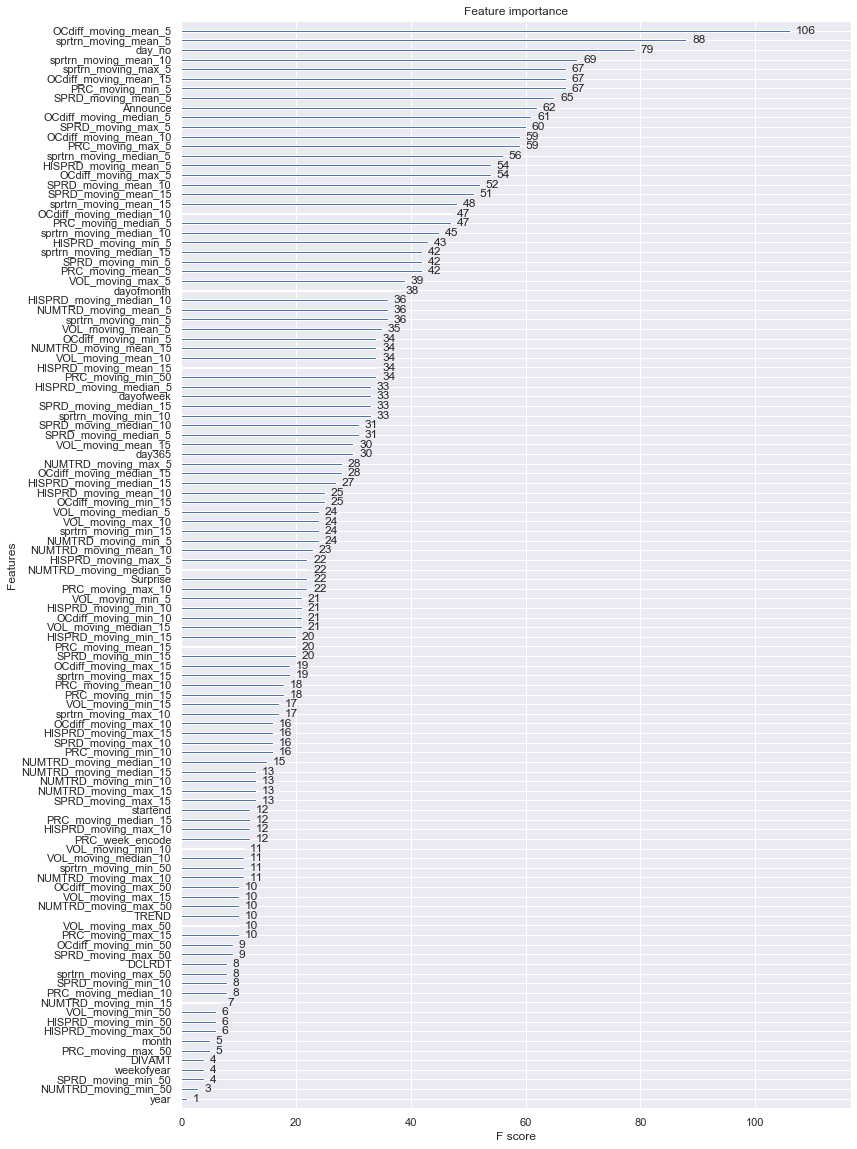

In [67]:
fig, ax = plt.subplots(figsize=(12, 20))
plot_importance(model, ax=ax);

In [235]:
y_pred = model.predict(X_test)
print('RMSE of test prediction:', rmse(y_pred, y_test))
print('MAPE of test prediction:', mape(y_pred, y_test))

RMSE of test prediction: 10.06715569962731
MAPE of test prediction: 5.615503165538464


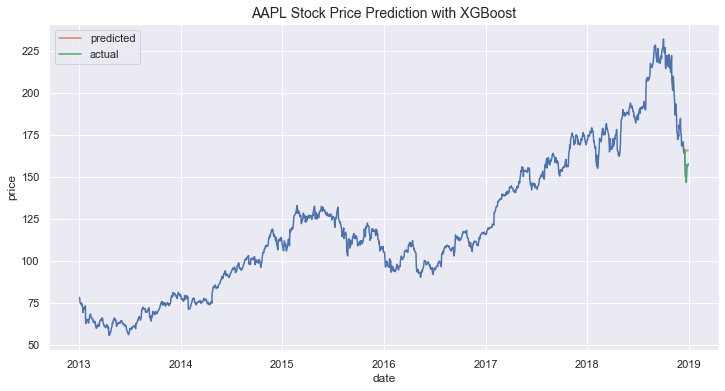

In [236]:
plt.figure(figsize=(12,6))
plt.plot(AAPL_Clean.set_index('date')['PRC'])
plt.plot(test_data['date'], y_pred, label='predicted')
plt.plot(test_data.set_index('date')['PRC'], label='actual')
plt.xlabel('date')
plt.ylabel('price')
plt.title('AAPL Stock Price Prediction with XGBoost', size=14)
plt.legend();

## Summary of Results

In [26]:
summary_error = [15.26, 10.86, 52.03, 10.74, 10.07,]
summary_model = ['Simple Moving Avg', 'AutoARIMA', 'FB Prophet', 'XGBoost (price based)', 'XGBoost (multiple features)']

pd.DataFrame(list(zip(summary_model, summary_error)), columns = ['Model', 'RMSE'])


,Model,RMSE
0,Simple Moving Avg,15.26
1,AutoARIMA,10.86
2,FB Prophet,52.03
3,XGBoost (price based),10.74
4,XGBoost (multiple features),10.07


The model with the lowest RMSE is XGBoost with features constructed from a variety of variables. The model with the highest RMSE is FB Prophet. 